# 15688 Final Project

## Table of Contents
* [1. Data Collection](#scrape)
* &emsp;&emsp;&emsp;[1-1. API Introduction](#scrape-1)
* &emsp;&emsp;&emsp;[1-2. Data Scraping](#scrape-2)
* [2. Data Cleaning](#cleaning)
* &emsp;&emsp;&emsp;[2-1. Read the data for question 1](#cleaning-1)
* &emsp;&emsp;&emsp;[2-2. Read the data for question 2](#cleaning-2)
* [3. Discriptive Analysis](#discriptive)
* [4. Winning Probability Prediction](#prediction)
* &emsp;&emsp;&emsp;[4-1. Hero Selection Influence](#prediction-1)
* &emsp;&emsp;&emsp;[4-2. Real-time Precition](#prediction-2)
* [5. Conclusion](#conclusion)
* [REFENRECES](#ref)

In [39]:
import json
import glob
import requests
import operator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from IPython.display import Markdown, display
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier 
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier

<a name="scrape"></a>
## 1. Data Collection

*** Dota2 *** is a super popular Multiplayer online battle arena (moba) game on Steam.

![](http://esportsjunkie.com/wp-content/uploads/2016/12/Dota2-Logo.jpg?raw=true)

In this game, ten players are divided into two teams and each player will choose one **hero** to fight for him. 

During the match, the heroes fight and gain **experience** and **golds** to be stronger and get better equipment.

Finally ,the team who destroy the **ancient** of enemy will win the victory. 

Each year, thousands of professional teams are competing for high rewards in different tourments. When we are watching the game, we often want to ask these two questions:

1. Which team's hero selection is better?

2. Which team has a better chance to win in the middle of the game?

To answer these two questions, we collected data from more than **49,000** professional matches with **opendota API**, and we hope to get some clues from it.

<a name="scrape-1"></a>
### 1-1. API Introduction

In *** opendota API***, we can use sql query to get the data we want. 

Here is the schema for **matches** and **player_matches** that we use in this project.

```sql
--overall information for one match
CREATE TABLE IF NOT EXISTS matches (
  match_id bigint PRIMARY KEY,
  match_seq_num bigint,
  radiant_win boolean,
  start_time integer,
  duration integer,
  tower_status_radiant integer,
  tower_status_dire integer,
  first_blood_time integer,
  human_players integer,
  leagueid integer,
  game_mode integer,
  engine integer,
  radiant_score integer,
  dire_score integer,
  picks_bans json[],
  radiant_gold_adv integer[],
  radiant_xp_adv integer[],
  ...
);
```

```sql
--performance of one player in one match
CREATE TABLE IF NOT EXISTS player_matches (
  PRIMARY KEY(match_id, player_slot),
  match_id bigint REFERENCES matches(match_id) ON DELETE CASCADE,
  account_id bigint,
  player_slot integer,
  hero_id integer,
  item_0 integer,
  item_1 integer,
  item_2 integer,
  item_3 integer,
  item_4 integer,
  item_5 integer,
  backpack_0 integer,
  backpack_1 integer,
  backpack_2 integer,
  kills integer,
  deaths integer,
  assists integer,
  leaver_status integer,
  gold integer,
  last_hits integer,
  gold_per_min integer,
  xp_per_min integer,
  gold_spent integer,
  hero_damage integer,
  tower_damage bigint,
  hero_healing bigint,
  level integer,
  gold_t integer[],
  lh_t integer[],
  dn_t integer[],
  xp_t integer[],
  obs_log json[],
  sen_log json[],
  obs_left_log json[],
  sen_left_log json[],
  purchase_log json[],
  kills_log json[],
  buyback_log json[],
  lane_pos json,
  obs json,
  sen json,
  actions json,
  pings json,
  purchase json,
  killed json,
  killed_by json,
  ...
);
```

<a name="scrape-2"></a>
### 1-2. Data Scraping

Below is the code we use to get data of all the professional matches after **2014**.

In [40]:
def get_data_from_query(query):
    params = {"sql": query}
    explorer_url = 'https://api.opendota.com/api/explorer'
    dac_response = requests.get(explorer_url, params = params)
    return dac_response.json()['rows']

In [4]:
query1 = 'SELECT * FROM MATCHES WHERE start_time > 1388552400' # after 2014
query2 = 'SELECT * FROM PLAYER_MATCHES WHERE match_id > 3038294356' # after 2014

In [5]:
# data1 = get_data_from_query(query1)
# data2 = get_data_from_query(query2)

<a name="cleaning"></a>
## 2. Data Cleaning
As the data from the two APIs is in JSON format, the data we scraped is actually in a very good format. What we mainly did in the data preprocessing part were 

> * 1) transformed the data into a dataframe format
> * 2) picked the features we want
> * 3) dropped the missing values (as there were only a few missing values in the data)
> * 4) did one-hot encoding or normalization. 

Our detailed processes will be discussed in the following.

<a name="cleaning-1"></a>
### Read the data for Question 1
For the first question, we extracted the information of hero selection (in field ** picks_bans **) and final result (in filed **radiant_win**) from the raw data we collected, and did one-hot encoding for the hero seletion data.

In [37]:
def read_file_into_dict_of_list(filename):
    with open(filename) as f:
        o = []
        for line in f:
            d = json.loads(line)
            o.append(d)
        f.close()
        return o

In [38]:
# read the file for sovling the first question
filename = 'data_sum.txt' # data1
data1 = pd.DataFrame(read_file_into_dict_of_list(filename))

In [7]:
data1.head()

,barracks_status_dire,barracks_status_radiant,chat,cluster,cosmetics,dire_captain,dire_score,dire_team_complete,dire_team_id,dire_team_name,...,radiant_team_complete,radiant_team_id,radiant_team_name,radiant_win,radiant_xp_adv,start_time,teamfights,tower_status_dire,tower_status_radiant,version
0,63,3,None,223,None,NaN,0,1.0,7.0,None,...,1.0,5.0,None,False,None,1388564360,None,2047,1540,NaN
1,59,63,"[{'time': 1734, 'type': 'chat', 'unit': 'iG.YY...",222,{},NaN,0,1.0,5.0,None,...,1.0,7.0,None,True,[],1388568272,[],1796,2046,20.0
2,63,48,None,223,None,NaN,0,1.0,7.0,None,...,1.0,5.0,None,False,None,1388571290,None,1959,1792,NaN
3,63,63,"[{'time': 2443, 'type': 'chat', 'unit': 'iG.Fa...",223,{},NaN,0,1.0,5.0,None,...,1.0,7.0,None,True,[],1388579278,[],1828,2047,20.0
4,51,63,None,231,None,NaN,0,1.0,999689.0,None,...,1.0,7.0,None,True,None,1388739010,None,1796,2046,NaN


#### Select the needed features & Drop missing values

In [41]:
hero_matches_data = data1[['picks_bans', 'radiant_win']]

# drop the missing values
hero_matches_data = hero_matches_data.dropna(axis=0, how='any').reset_index().drop('index', axis = 1)

# extract the initial battle formation data from data1
team0_hero = []
team1_hero = []
for i in range(len(hero_matches_data)):
    team0_list = []
    team1_list = []
    bans = hero_matches_data.iloc[i]['picks_bans']
    for ban in bans:
        if ban['is_pick']:
            if ban['team'] == 0:
                team0_list.append(ban['hero_id'])
            else:
                team1_list.append(ban['hero_id'])
    team0_hero.append(team0_list)
    team1_hero.append(team1_list)

# assign the new columns to the dataset
hero_matches_data = hero_matches_data.assign(team0 = team0_hero, team1 = team1_hero)
hero_matches_data['radiant_win'] = hero_matches_data['radiant_win'].apply(lambda x: 1 if x is True else 0)
hero_matches_data.drop('picks_bans', axis = 1, inplace = True)

In [42]:
hero_matches_data.head()

,radiant_win,team0,team1
0,0,"[92, 86, 103, 67, 97]","[53, 49, 79, 56, 23]"
1,1,"[40, 58, 49, 99, 45]","[92, 51, 69, 87, 63]"
2,0,"[49, 98, 58, 20, 45]","[53, 76, 79, 16, 47]"
3,1,"[40, 58, 91, 19, 16]","[49, 51, 79, 9, 31]"
4,1,"[92, 99, 17, 54, 40]","[51, 5, 48, 13, 87]"


#### One-hot encoding

In [43]:
clean_data1 = hero_matches_data.copy()

# change the multiple-value columns into one-hot encoding
# the prefix is the name of each column
for col in ['team1','team0']:
    onehotdf = pd.get_dummies(
            pd.DataFrame(list(clean_data1[col])).stack(),
            prefix = col
        ).astype(int).sum(level = 0)
    
    clean_data1 = clean_data1.drop(col, axis = 1).join(onehotdf)

In [44]:
clean_data1.head()

,radiant_win,team1_1,team1_2,team1_3,team1_4,team1_5,team1_6,team1_7,team1_8,team1_9,...,team0_107,team0_108,team0_109,team0_110,team0_111,team0_112,team0_113,team0_114,team0_119,team0_120
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<a name="cleaning-1"></a>
### Read the data for Question 2
For question 2, we combined **matches** and **player_matches** data, extracted **gold**, **exp**, **level**, **kill** information of each player in every minute as well as **hero_selection** of the entire match (stored in file **data_timeline.txt**), and did one hot-encoding for the **hero_selection**.

In [45]:
def convert_df_to_player_df(df):
    team0_column_names = ['hero_id_0','hero_id_1', 'hero_id_2', 'hero_id_3', 'hero_id_4']
    team1_column_names = ['hero_id_5','hero_id_6', 'hero_id_7', 'hero_id_8', 'hero_id_9']
    team0_df = sum([pd.get_dummies(df[team0_name], prefix = 'team0') for team0_name in team0_column_names])
    team1_df = sum([pd.get_dummies(df[team1_name], prefix = 'team1') for team1_name in team1_column_names])
    df1 = pd.concat([df,team0_df,team1_df], axis = 1)
    return df1.dropna(axis = 1).drop(['hero_id_0','hero_id_1','hero_id_2', 'hero_id_6', \
                                      'hero_id_3','hero_id_4','hero_id_5', 'hero_id_7', \
                                      'hero_id_8','hero_id_9','match_id'], axis = 1)

In [9]:
# read the file for sovling the second question
filename = 'data_timeline.txt'# data2 
df = pd.DataFrame(read_file_into_dict_of_list(filename))
data2 = convert_df_to_player_df(df)

In [10]:
data2.head()

,gold_t_0,gold_t_1,gold_t_2,gold_t_3,gold_t_4,gold_t_5,gold_t_6,gold_t_7,gold_t_8,gold_t_9,...,team1_90,team1_91,team1_92,team1_93,team1_94,team1_95,team1_96,team1_97,team1_98,team1_99
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,100,100,139,395,273,100,100,282,283,100,...,1,0,0,0,0,0,0,0,0,0
2,200,200,239,613,693,225,300,619,539,200,...,1,0,0,0,0,0,0,0,0,0
3,354,354,659,1042,1073,379,494,989,914,300,...,1,0,0,0,0,0,0,0,0,0
4,1071,454,1004,1326,1321,479,748,1089,1222,500,...,1,0,0,0,0,0,0,0,0,0


<a name="discriptive"></a>
## 3. Discriptive Analysis
### 1) The winning frequencies for both team
From the graph, we could see that actually the winning times for two team are almost the same.

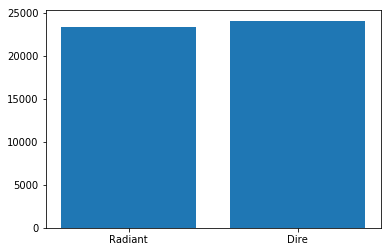

In [47]:
plt.bar(list(Counter(hero_matches_data['radiant_win']).keys()), list(Counter(hero_matches_data['radiant_win']).values()))
plt.xticks(list(Counter(hero_matches_data['radiant_win']).keys()), ('Radiant','Dire'))
plt.show()

### 2) What's the most & least popular heroes for Radiant team?

In [48]:
# Radiant
for col in ['team0']:
    formation_list = []
    for formation in hero_matches_data[col]:
        formation_list += [str(f) for f in formation]
    c0 = Counter(formation_list)
    
c0 = {k:v for v,k in c0.items()}

# the most & least frequent used heros
print('MOST FREQUENT USED HEROS FOR RADIANT')
print(sorted(c0.items(), reverse = True)[:10])
print()
print('LEAST FREQUENT USED HEROS FOR RADIANT')
print(sorted(c0.items(), reverse = True)[-10:])
print()

MOST FREQUENT USED HEROS FOR RADIANT
[(5238, '86'), (4935, '20'), (4714, '87'), (4667, '7'), (4363, '30'), (4352, '65'), (4314, '74'), (4073, '16'), (4003, '8'), (3904, '50')]

LEAST FREQUENT USED HEROS FOR RADIANT
[(670, '14'), (659, '114'), (598, '59'), (595, '81'), (531, '108'), (511, '82'), (136, '119'), (89, '113'), (62, '105'), (45, '120')]



**Most popular hero for radiant**|**Least popular hero for radiant**|
:-|:-|
**Rubick (id: 86)**|**Pangolier Pangolier (id:120)**
<img src="https://github.com/yunluhuang516/pictures/raw/master/project/86.jpeg" style="width: 200px;"/>|<img src="https://d1u5p3l4wpay3k.cloudfront.net/dota2_gamepedia/4/4e/Pangolier_icon.png?version=d53e7d6702dd85fef483551207cf40db" style="width: 200px;"/>

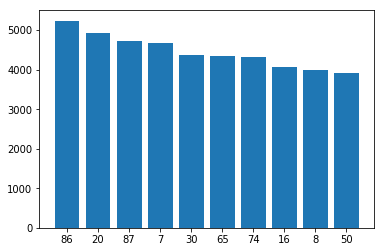

In [49]:
# MOST FREQUENT USED HEROS FOR RADIANT
plt.bar(range(0,10), [a[0] for a in sorted(c0.items(), reverse = True)[:10]])
plt.xticks(range(0,10), [a[1] for a in sorted(c0.items(), reverse = True)[:10]])
plt.show()

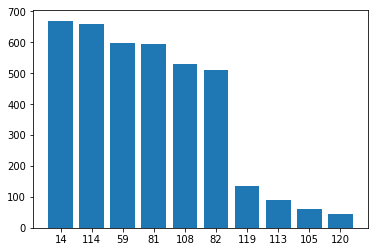

In [50]:
# LEAST FREQUENT USED HEROS FOR RADIANT
plt.bar(range(0,10), [a[0] for a in sorted(c0.items(), reverse = True)[-10:]])
plt.xticks(range(0,10), [a[1] for a in sorted(c0.items(), reverse = True)[-10:]])
plt.show()

### 3) What's the most & least popular heroes for Dire team

In [51]:
# Dire
for col in ['team1']:
    formation_list = []
    for formation in hero_matches_data[col]:
        formation_list += [str(f) for f in formation]
    c1 = Counter(formation_list)
    
c1 = {k:v for v,k in c1.items()}

# the most & least frequent used heros
print('MOST FREQUENT USED HEROS FOR DIRE')
print(sorted(c1.items(), reverse = True)[:10])
print()
print('LEAST FREQUENT USED HEROS FOR DIRE')
print(sorted(c1.items(), reverse = True)[-10:])
print()

MOST FREQUENT USED HEROS FOR DIRE
[(5195, '20'), (5070, '86'), (4635, '87'), (4390, '74'), (4306, '30'), (4273, '65'), (4224, '7'), (3978, '8'), (3926, '16'), (3739, '39')]

LEAST FREQUENT USED HEROS FOR DIRE
[(662, '114'), (631, '81'), (601, '14'), (579, '59'), (565, '108'), (436, '82'), (131, '119'), (93, '113'), (60, '105'), (35, '120')]



**Most popular hero for dire**|**Least popular hero for dire**|
:-|:-|
**Vengefulspirit (id: 86)**|**Pangolier (id:120)**
<img src="https://github.com/yunluhuang516/pictures/raw/master/project/20.jpeg" style="width: 200px;"/>|<img src="https://d1u5p3l4wpay3k.cloudfront.net/dota2_gamepedia/4/4e/Pangolier_icon.png?version=d53e7d6702dd85fef483551207cf40db" style="width: 200px;"/>

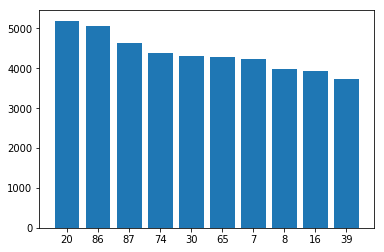

In [52]:
plt.bar(range(0,10), [a[0] for a in sorted(c1.items(), reverse = True)[:10]])
plt.xticks(range(0,10), [a[1] for a in sorted(c1.items(), reverse = True)[:10]])
plt.show()

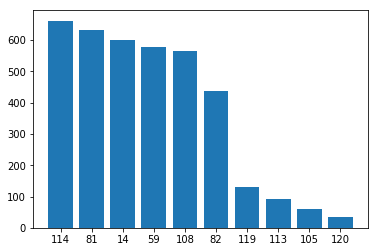

In [53]:
plt.bar(range(0,10), [a[0] for a in sorted(c1.items(), reverse = True)[-10:]])
plt.xticks(range(0,10), [a[1] for a in sorted(c1.items(), reverse = True)[-10:]])
plt.show()

<a name="prediction"></a>
## 4. Winning Probability Prediction

<a name="prediction-1"></a>
### 4-1. Hero Selection Influence
As we all know, different heroes might restrict or complement to each other. Thus, we might think the hero selection is crucial to the final result.

We tried three models and use cross-validation to choose the best parameters. We used the accuracy and the ROC curves to check whether our models gave good predictions.

### 1) Get training & testing dataset
We used GridSearchCV in sklearn to choose the best parameters. 

It will automatically do the k-fold cross validation (k is determined by the user's input) and tell you the best parameters combination. 

The evaluation score could be average precision, recall rate etc. Detailed documentation can be found here:

    http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In order to draw the ROC curves, we trained the models with the best parameters using the training data and drew the ROC curves on the testing data. We used train_test_split function in sklearn. 

It can split arrays or matrices into random train and test subsets. Detailed documentation could be found here:

    http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html


In [54]:
# get the X, y from the dataset as well as the tranining & testing dataset
X = clean_data1.drop('radiant_win',axis = 1).values
y = clean_data1['radiant_win']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

### 2) Model training

#### Logistic Regression
The advantage of LR is it can be trained very fast. However, it's only suitable for the data which can be calssified by a single straight line.

We tried different regularization values, and fit the final model using the best parameters. 

We also tried the accuracy in extreme predicted cases. We filtered the data which are predicted to have a winning probability higher than 0.55 (or lower than 0.45). In these cases, the accuracy goes up (from 0.56 to around 0.60). 

We want to conclude that, in the normal cases (the predicted winning probabilities are between 0.45 and 0.55), our model does a little better than a random guess. However, when the initial batter formation leads to an extreme prediction, our model does better than it does in the normal cases.

In [15]:
# define the parameter values that should be searched
param_grid = {"C": [0.05, 0.1, 0.5, 1]}
lr = LogisticRegression()

# instantiate the grid
# AP summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold
# with the increase in recall from the previous threshold used as the weight
grid = GridSearchCV(lr, param_grid, cv = 5, scoring = 'average_precision')

# fit the grid with data
grid.fit(X, y)

# examine the best model
print(grid.best_score_)
print(grid.best_params_) 
print(grid.best_estimator_)

0.561369172636296
{'C': 0.05}
LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [55]:
# fit the model with the best params
# get the ROC params
lr = LogisticRegression(C = 0.05)
pred_y = lr.fit(X_train, y_train).predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, pred_y)

In [56]:
# use the threshold to find the extreme initial battle formation situation
threshold = 0.45
print('Real win rate for estimated win rate < 0.45: ', round(np.mean(y_test[pred_y < threshold]),3))
print('Real win rate for estimated win rate > 0.55: ',round(np.mean(y_test[pred_y > (1-threshold)]),3))

Real win rate for estimated win rate < 0.45:  0.445
Real win rate for estimated win rate > 0.55:  0.58


#### Random Forests
RF can give a more stable and accurate prediction in some cases because it aggregates many decision trees' outputs. RF can also capture the relationship among different features' pairs.

The three most important features in determined the outputs are **dragon_knight (id:9)**, **bristleback (id:99)**, and **bounty_hunter (id:62)**.
<img src="https://github.com/yunluhuang516/pictures/raw/master/project/important.png" style="width: 600px;"/>

In [19]:
# define the parameter values that should be searched
param_grid = {"max_depth": [None, 10, 15, 20], 
              "n_estimators":[10, 20, 40],
               "max_features": [10, 20, 40]}
rf = RandomForestClassifier(random_state=10)

# instantiate the grid
grid = GridSearchCV(rf, param_grid, cv = 5, scoring = 'average_precision')

# fit the grid with data
grid.fit(X, y)

# examine the best model
print(grid.best_score_)
print(grid.best_params_)  
print(grid.best_estimator_)

0.5502314495567728
{'max_depth': 10, 'max_features': 20, 'n_estimators': 40}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=20, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=1,
            oob_score=False, random_state=10, verbose=0, warm_start=False)


In [57]:
# fit the model with the best params
rf = RandomForestClassifier(max_depth = 10, max_features = 20, n_estimators = 40)
pred_y = rf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, pred_y)

In [58]:
# get the 3 most importantce params in the random forest
importance = {}
for i in range(len(clean_data1.drop('radiant_win',axis = 1).columns)):
    importance[clean_data1.drop('radiant_win',axis = 1).columns[i]] = rf.feature_importances_[i]  
tmp = {k:v for v,k in importance.items()}
print(sorted(tmp.items(), reverse = True)[:3])
# num.9 :dragon_knight
# num.99 :bristleback
# num.62 :bounty_hunter

[(0.026622091958273343, 'team0_99'), (0.018137986981071049, 'team0_9'), (0.017461576286228058, 'team1_77')]


In [59]:
# use the threshold to find the extreme initial battle formation situation
threshold = 0.45
print('Real win rate for estimated win rate < 0.45: ', round(np.mean(y_test[pred_y < threshold]),3))
print('Real win rate for estimated win rate > 0.55: ',round(np.mean(y_test[pred_y > (1-threshold)]),3))

Real win rate for estimated win rate < 0.45:  0.395
Real win rate for estimated win rate > 0.55:  0.627


#### Naive Bayes
NB calculated the conditional maximum probability of each features so we also tried this model. However, NB could not figure out the inner relationship within different features' paris as it assumes the features are independent to other features.

In [60]:
nb = GaussianNB()
pred_y = nb.fit(X_train, y_train).predict_proba(X_test)[:, 1]
fpr_nb, tpr_nb, _ = roc_curve(y_test, pred_y)

#### ROC CURVE
As learned in the class, if the curve is similar to a straight line, it means the model performs similar to a random guess. If the curve is more close to the left-up-corner, it means the model performs more perfect.
The codes for plotting the ROC curves are learned from here:

    http://scikit-learn.org/stable/auto_examples/ensemble/plot_feature_transformation.html#sphx-glr-auto-examples-ensemble-plot-feature-transformation-py


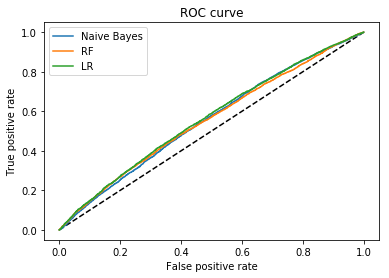

In [61]:
# Author: scikit-learn.org
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_nb, tpr_nb, label='Naive Bayes')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

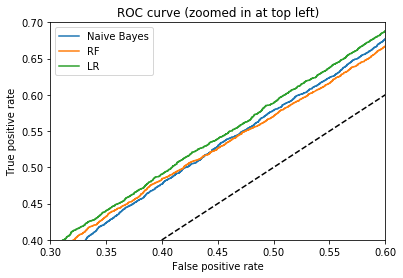

In [62]:
# Author: scikit-learn.org
plt.figure(2)
plt.xlim(0.3, 0.6)
plt.ylim(0.4, 0.7)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_nb, tpr_nb, label='Naive Bayes')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

### 3) Recommandation System based on RF

From our point of view, these results can work although it just looks a little bit better than a random guess! Dota2 is a fair game so we shouldn't dream to win only from selecting a better formation. However, from the result, we know the initial formation indeed has some influence of the final results!

Based on our random forests model, we created a hero selection system. Given 9 heroes selected by other players, the system will calculate which hero can lead to a higher winning probability and then give 3 recommendations for the 10th player. 

In our example, we could see the predicted winning probabilities of choosing these three heroes are around 0.55. Higher than a tie!

In [63]:
query = "SELECT * FROM heroes"
heros = pd.DataFrame(get_data_from_query(query))
heros['name_mod'] = heros['name'].apply(lambda x: x[14:])
heros['pic_url'] = 'http://cdn.dota2.com/apps/dota2/images/heroes/'+ heros['name_mod'] +'_hphover.png'

In [64]:
class display_info:
    def __init__(self, heros):
        self.heros = heros
        
    def printmd(self, string):
        display(Markdown(string))
        
    def get_png(self, hero_id):
        png_url = self.heros[self.heros['id'] == hero_id]['pic_url'].values[0]
        return '![](%s?raw=true)'%png_url
    
    def print_recommand_func(self, hero_list1, hero_list2, recommand_heros):
        png_list1 = [self.get_png(hero) for hero in hero_list1]
        png_list2 = [self.get_png(hero) for hero in hero_list2]
        png_recommand_list = [self.get_png(hero[0]) for hero in recommand_heros]
        
        result_struct = '### Radiant \n\n Hero1|Hero2|Hero3|Hero4|Hero5|\n:-|:-|:-|:-|:-|\n'
        if len(hero_list1) == 4:
            result_struct += '%s | %s | %s | %s | \n' % (png_list1[0],png_list1[1],png_list1[2],png_list1[3])
            result_struct += '### Dire \n\n Hero1|Hero2|Hero3|Hero4|Hero5|\n:-|:-|:-|:-|:-|\n'
            result_struct += '%s | %s | %s | %s | %s | \n' % (png_list2[0],png_list2[1],png_list2[2],png_list2[3],png_list2[4])
        else:
            result_struct += '%s | %s | %s | %s | %s | \n' % (png_list1[0],png_list1[1],png_list1[2],png_list1[3],png_list1[4])
            result_struct += '### Dire \n\n Hero1|Hero2|Hero3|Hero4|Hero5|\n:-|:-|:-|:-|:-|\n'
            result_struct += '%s | %s | %s | %s | \n' % (png_list2[0],png_list2[1],png_list2[2],png_list2[3])
            
        result_struct += '### Recommandation \n\n Hero1|Hero2|Hero3|\n:-|:-|:-|\n'
        result_struct += '%s *** winning rate: %.2f ***|%s *** winning rate: %.2f ***|%s *** winning rate: %.2f ***|\n' % \
                        (png_recommand_list[0],recommand_heros[0][1],\
                        png_recommand_list[1],recommand_heros[1][1],\
                        png_recommand_list[2],recommand_heros[2][1])
        self.printmd(result_struct)

In [65]:
class recommand_func:
    def __init__(self, model):
        self.model = model
    
    def right_columns(self, num, team0):
        if team0:
            if num > 24:
                if num > 115:
                    return num - 6
                else:
                    return num - 2
            else:
                return num - 1
        else:
            if num > 24:
                if num > 115:
                    return 120 + num - 11
                else:
                    return 120 + num - 7
            else:
                return 120 + num - 6
    
    def build_X(self, hero_list1, hero_list2):
        X = np.zeros(230)
        for i in hero_list1:
            X[self.right_columns(i,True)] = 1
        for i in hero_list2:
            X[self.right_columns(i,False)] = 1
        out = []
        out.append(X)
        return np.array(out)
    
    def compute_win_rate(self, hero_list1, hero_list2):
        if len(hero_list1) == 4:
            add_list1 = True
        else:
            add_list1 = False
        
        hero_nums = set(hero_list1 + hero_list2)
        ban_list = [1,25,115,116,117,118]
        rate_dict = {}
        
        for i in range(120):
            if (i+1) not in hero_nums and (i+1) not in ban_list:
                hero_list1_final = list(hero_list1)
                hero_list2_final = list(hero_list2)
                if add_list1:
                    hero_list1_final.append(i+1)
                else:
                    hero_list2_final.append(i+1)
                
                X = self.build_X(hero_list1_final, hero_list2_final)
                pred = self.model.predict_proba(X)
                rate_dict[i+1] = pred[0][1]
        return rate_dict
    
    def recommand_hero(self, hero_list1, hero_list2):
        rate_dict = self.compute_win_rate(hero_list1, hero_list2)
        arr = sorted(rate_dict.items(), key=lambda x: x[1], reverse = True)
        return arr[:3]

In [67]:
# create the initial battle formation sample
list1 = [68,5,99,11]
list2 = [22,6,33,105,104]

# do the recommendation
rfc = recommand_func(rf)
rcmd = rfc.recommand_hero(list1,list2)
diinfo = display_info(heros)
diinfo.print_recommand_func(list1,list2,rcmd)

### Radiant 

 Hero1|Hero2|Hero3|Hero4|Hero5|
:-|:-|:-|:-|:-|
![](http://cdn.dota2.com/apps/dota2/images/heroes/ancient_apparition_hphover.png?raw=true) | ![](http://cdn.dota2.com/apps/dota2/images/heroes/crystal_maiden_hphover.png?raw=true) | ![](http://cdn.dota2.com/apps/dota2/images/heroes/bristleback_hphover.png?raw=true) | ![](http://cdn.dota2.com/apps/dota2/images/heroes/nevermore_hphover.png?raw=true) | 
### Dire 

 Hero1|Hero2|Hero3|Hero4|Hero5|
:-|:-|:-|:-|:-|
![](http://cdn.dota2.com/apps/dota2/images/heroes/zuus_hphover.png?raw=true) | ![](http://cdn.dota2.com/apps/dota2/images/heroes/drow_ranger_hphover.png?raw=true) | ![](http://cdn.dota2.com/apps/dota2/images/heroes/enigma_hphover.png?raw=true) | ![](http://cdn.dota2.com/apps/dota2/images/heroes/techies_hphover.png?raw=true) | ![](http://cdn.dota2.com/apps/dota2/images/heroes/legion_commander_hphover.png?raw=true) | 
### Recommandation 

 Hero1|Hero2|Hero3|
:-|:-|:-|
![](http://cdn.dota2.com/apps/dota2/images/heroes/slark_hphover.png?raw=true) *** winning rate: 0.59 ***|![](http://cdn.dota2.com/apps/dota2/images/heroes/shredder_hphover.png?raw=true) *** winning rate: 0.58 ***|![](http://cdn.dota2.com/apps/dota2/images/heroes/magnataur_hphover.png?raw=true) *** winning rate: 0.57 ***|


<a name="prediction-2"></a>
### 4-2. Real-time Precition

Here we extracted X, y from **data2** (the dataset that contains the information in every minute of all the matches), X for all features including **gold**, **exp**, **level**, **kill**, **hero_selection**, and y for the final result. Then we splited them into train set and test set.

In [11]:
X = data2.drop('radiant_win', axis = 1).values
y = data2['radiant_win'].values.astype(int)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

### Logisitic Regression

Firstly, we trid to use **logistic regression** to see the performance of **winning rate prediction**.

In [23]:
# define the parameter values that should be searched
param_grid = {"C": [0.05, 0.1, 0.5, 1]}
lr = LogisticRegression()

# instantiate the grid
# AP summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold
# with the increase in recall from the previous threshold used as the weight
grid = GridSearchCV(lr, param_grid, cv = 5, scoring = 'average_precision')

# fit the grid with data
grid.fit(X, y)

# examine the best model
print(grid.best_score_)
print(grid.best_params_) 
print(grid.best_estimator_)

0.843140337039
{'C': 1}
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [24]:
# fit the model with the best params
# get the ROC params
lr = LogisticRegression(C = 0.05)
pred_y = lr.fit(X_train, y_train).predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, pred_y)

### Naive Bayes

Next we tried to use **Naive Bayes** model to see the performance of **winning rate prediction**.

In [25]:
nb = GaussianNB()
pred_y = nb.fit(X_train, y_train).predict_proba(X_test)[:, 1]
fpr_nb, tpr_nb, _ = roc_curve(y_test, pred_y)

### Random Forest

 Here we tried to use **Random Forest** model to see the performance of **winning rate prediction**.

In [17]:
# define the parameter values that should be searched
param_grid = {"max_depth": [None, 10, 15, 20], 
              "n_estimators":[10, 20, 40],
               "max_features": [10, 20, 40]}
rf = RandomForestClassifier(random_state=10)

# instantiate the grid
grid = GridSearchCV(rf, param_grid, cv = 5, scoring = 'average_precision')

# fit the grid with data
grid.fit(X_train, y_train)

# examine the best model
print(grid.best_score_)
print(grid.best_params_)  
print(grid.best_estimator_)

0.99441861137
{'max_depth': None, 'max_features': 10, 'n_estimators': 40}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=1,
            oob_score=False, random_state=10, verbose=0, warm_start=False)


In [19]:
# fit the model with the best params
rf = RandomForestClassifier(n_estimators = 40, max_depth = None, max_features = 10)
pred_y = rf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, pred_y)

### ROC Curve

Here we drew the ROC curve to compare the performance of three models.

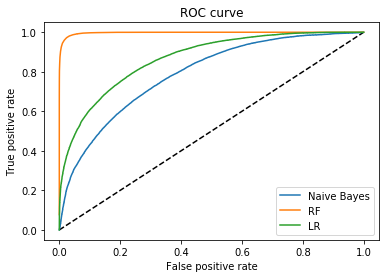

In [26]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_nb, tpr_nb, label='Naive Bayes')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Comparing these models, we found the **score** and **accuracy** of **random forest** is highest among the three. 

Also, from the discussion above, we believed that random forest is very suitable for solving this problem. 

So next, we were trying to use this model to analyse one latest match: **PSG.LGD VS TEAM.LIQUID** and see how it performs.

### One match analysis

First we collected data with **opendota api** and parsed it into the form we expect.

In [27]:
# final match of EPICENTER XL
# PSG.LGD VS TEAM.LIQUID
match_data_opendota = requests.get('https://api.opendota.com/api/matches/3870838763').json()

In [28]:
column_names = list(data2.drop('radiant_win', axis = 1).columns)

In [29]:
team_hero = column_names[41:]

In [30]:
out = []
minutes = len(match_data_opendota['players'][0]['gold_t'])
for i in range(minutes):
    o = {}
    o['time'] = i
    
    t = i * 60
    for j in range(10):
        
        
        o['gold_t_'+str(j)] = match_data_opendota['players'][j]['gold_t'][i]
        o['lh_t_'+str(j)] = match_data_opendota['players'][j]['lh_t'][i]
        o['xp_t_'+str(j)] = match_data_opendota['players'][j]['xp_t'][i]
        
        kill_log = match_data_opendota['players'][j]['kills_log']
        kill_count = 0
        for k in kill_log:
            if k['time'] <= t:
                kill_count += 1
        o['kills_count_'+str(j)] = kill_count

    for hero in team_hero:
        team = int(hero[4])
        hero_num = int(hero[6:])
        
        for j in range(10):
            player_hero = match_data_opendota['players'][j]['hero_id']
            if player_hero == hero_num:
                if (team == 0 and j < 5) or (team == 1 and j >= 5):
                    o[hero] = 1
                else:
                    o[hero] = 0
            else:
                o[hero] = 0
                
    out.append(o)

In [31]:
df_t  = pd.DataFrame(out)[column_names]

In [32]:
df_t.head()

,gold_t_0,gold_t_1,gold_t_2,gold_t_3,gold_t_4,gold_t_5,gold_t_6,gold_t_7,gold_t_8,gold_t_9,...,team1_90,team1_91,team1_92,team1_93,team1_94,team1_95,team1_96,team1_97,team1_98,team1_99
0,0,0,0,0,0,0,51,0,295,0,...,0,0,0,0,0,0,0,0,0,0
1,212,170,221,170,256,209,260,228,504,170,...,0,0,0,0,0,0,0,0,0,0
2,421,417,312,261,585,300,563,487,645,495,...,0,0,0,0,0,0,0,0,0,0
3,877,681,457,420,872,514,654,841,805,872,...,0,0,0,0,0,0,0,0,0,0
4,1162,992,548,511,1207,794,947,1101,1099,1143,...,0,0,0,0,0,0,0,0,0,0


Here we extracted the information of **gold**, **exp**, **level**, **kill** of each player at every minute as well as **hero_selection** for the entire match, set them as features of **X**, predicted the winning rate for **team 0** at every minute of this match by **X** and plotted it.

In [33]:
X = df_t.values

In [34]:
pred_y = rf.predict_proba(X)[:, 1]

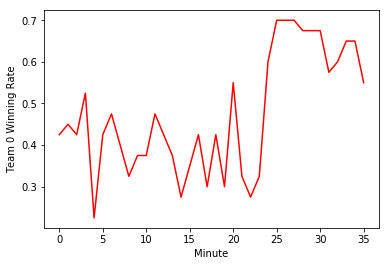

In [36]:
plt.plot(pred_y, color='red')
plt.xlabel('Minute')
plt.ylabel('Team 0 Winning Rate')
plt.show()

From the plot we see winning rate for team 0 changed drasticly during this match. This was a very exciting game. Even at last minute of this match you did not know which team would win the victory.

For the final result, **PSG.LGD (team 0)** win this match, so the final prediction from our model is still **correct** in this situation.

<a name="conclusion"></a>
## 5. Conclusion

**In this project, we collected data from more than 49,000 matches and mainly build two models based on it using random forest.**

**For the first model, we tried to predict winning rate based on the hero selection of each team. We hope this model could give DOTAers some indications on which team's hero selection is better when they are watching games and help them make decision on hero selection when they are playing.**

**For the second model, we tried to predict winning rate based on data of each minute during one match. We hope this could help DOTAers to get a better indication of which team has a better chance to win when they are watching it.**

**Though hero selection is important during a DOTA2 match, the key for winning a game is still the skill and performance. We hope these models could help DOTAers better enjoy in both watching and playing DOTA2.**

<a name="ref"></a>
## Refenreces

1. https://www.opendota.com/api-keys

2. http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

3. http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

4. http://scikit-learn.org/stable/auto_examples/ensemble/plot_feature_transformation.html#sphx-glr-auto-examples-ensemble-plot-feature-transformation-py